<a href="https://colab.research.google.com/github/evi1angel/40-Algorithms-Every-Programmer-Should-Know/blob/master/1_NN_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# Requirements
!pip install yahoo_fin

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.6 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=f392e6a5e2b148466d811f7d95d884ff16a45fe1ca1c33b4bfe862cf9f3cd9d7
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: websockets
    Found existing installation: websockets 14.1
    Uninstalling websockets-14.1:
      Successfully uninstalled websockets-14.1
  Attempting uninstall: url

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'QQQ'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [5]:
init_df

,open,high,low,close,adjclose,volume,ticker
2022-01-03,399.049988,401.940002,396.880005,401.679993,393.665924,40575900,QQQ
2022-01-04,402.239990,402.279999,393.290009,396.470001,388.559814,58027200,QQQ
2022-01-05,394.739990,395.890015,384.029999,384.290009,376.622864,75739800,QQQ
2022-01-06,382.420013,387.350006,380.130005,384.019989,376.358276,70814300,QQQ
2022-01-07,384.029999,385.760010,378.040009,379.859985,372.281219,72652300,QQQ
...,...,...,...,...,...,...,...
2025-01-03,513.349976,519.650024,512.530029,518.580017,518.580017,29059500,QQQ
2025-01-06,524.020020,527.919983,522.030029,524.539978,524.539978,36109700,QQQ
2025-01-07,525.590027,525.989990,513.280029,515.179993,515.179993,36690300,QQQ
2025-01-08,515.080017,516.919983,510.570007,515.270020,515.270020,30777800,QQQ


In [6]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [ ]:
init_df

,close,date
2019-09-09,60.263500,2019-09-09
2019-09-10,60.285000,2019-09-10
2019-09-11,61.000000,2019-09-11
2019-09-12,61.748501,2019-09-12
2019-09-13,62.001499,2019-09-13
...,...,...
2022-09-12,110.860001,2022-09-12
2022-09-13,104.320000,2022-09-13
2022-09-14,105.000000,2022-09-14
2022-09-15,102.910004,2022-09-15


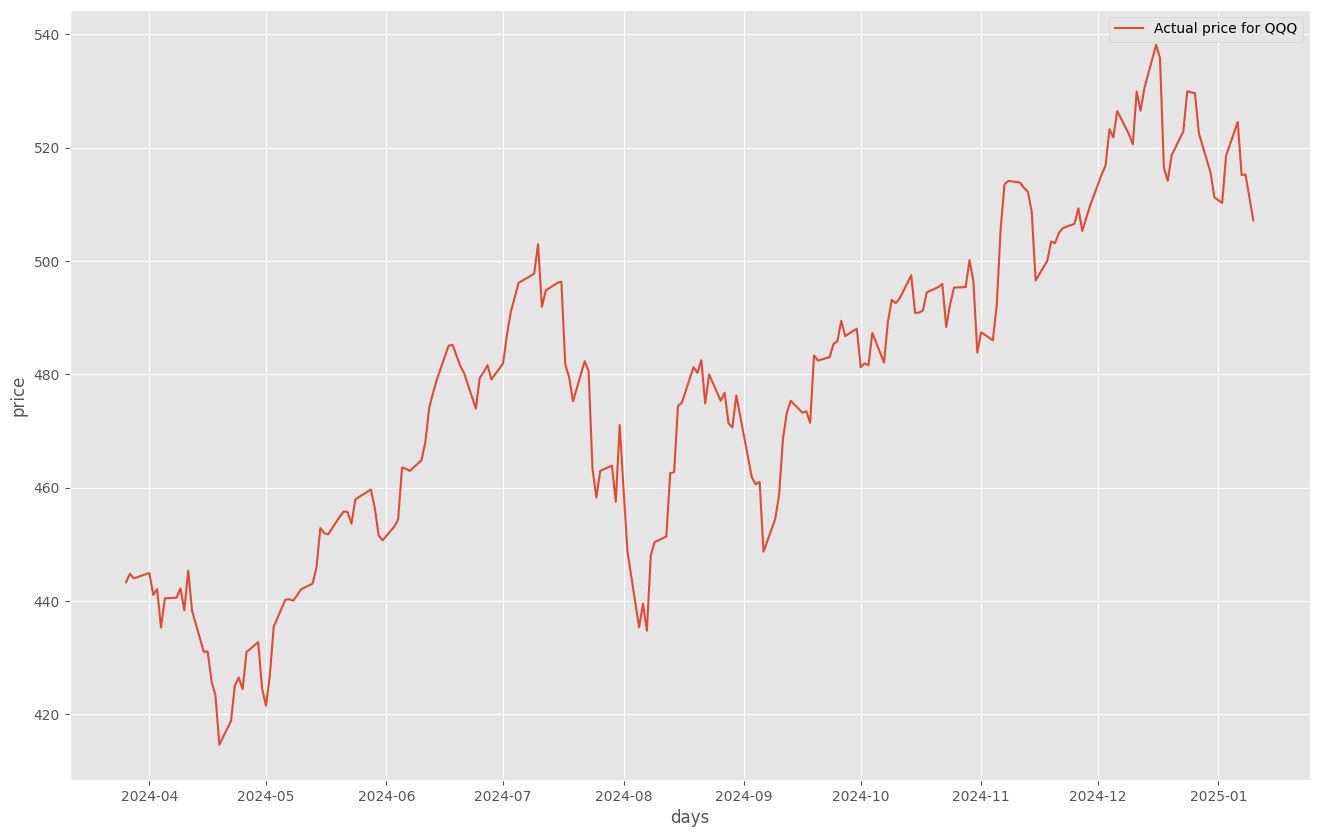

In [7]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [8]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [ ]:
init_df

,close,date,scaled_close
2019-09-09,60.263500,2019-09-09,0.077801
2019-09-10,60.285000,2019-09-10,0.078023
2019-09-11,61.000000,2019-09-11,0.085384
2019-09-12,61.748501,2019-09-12,0.093090
2019-09-13,62.001499,2019-09-13,0.095694
...,...,...,...
2022-09-12,110.860001,2022-09-12,0.598706
2022-09-13,104.320000,2022-09-13,0.531375
2022-09-14,105.000000,2022-09-14,0.538376
2022-09-15,102.910004,2022-09-15,0.516859


In [9]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [10]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2022-01-03  401.679993 2022-01-03      0.509152  0.445643
 2022-01-04  396.470001 2022-01-04      0.490416  0.430683
 2022-01-05  384.290009 2022-01-05      0.446614  0.431582
 2022-01-06  384.019989 2022-01-06      0.445643  0.452116
 2022-01-07  379.859985 2022-01-07      0.430683  0.457619
 ...                ...        ...           ...       ...
 2024-12-30  515.609985 2024-12-30      0.918869  0.929550
 2024-12-31  511.230011 2024-12-31      0.903118  0.950984
 2025-01-02  510.230011 2025-01-02      0.899522  0.917323
 2025-01-03  518.580017 2025-01-03      0.929550  0.917647
 2025-01-06  524.539978 2025-01-06      0.950984  0.888589
 
 [756 rows x 4 columns],
 array([[0.9691804 ],
        [0.9438631 ],
        [0.9188694 ],
        [0.903118  ],
        [0.89952177],
        [0.92955023],
        [0.9509835 ],
        [0.917323  ],
        [0.91764677],
        [0.88858926]], dtype=float32),
 array([[[0.5091523658834806

In [11]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [12]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0287
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0029
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0023
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016
Epoch 16/80
94/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0305
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0042
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0033
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0033
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0036
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0026
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0025
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0023
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0025
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023
Epoch 16/80
94/

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0409
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0037
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0038
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0036
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0027
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0028
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0028
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0027
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026
Epoch 16/80
94/

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


In [13]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

QQQ prediction for upcoming 3 days (501.97$, 501.5$, 491.2$)


In [14]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
copy_df

,close,date,scaled_close,predicted_close
2019-09-09,60.263500,2019-09-09,0.077801,61.492001
2019-09-10,60.285000,2019-09-10,0.078023,61.734501
2019-09-11,61.000000,2019-09-11,0.085384,60.916500
2019-09-12,61.748501,2019-09-12,0.093090,62.297001
2019-09-13,62.001499,2019-09-13,0.095694,62.114498
...,...,...,...,...
2022-09-12,110.860001,2022-09-12,0.598706,110.839371
2022-09-13,104.320000,2022-09-13,0.531375,111.554169
2022-09-14,105.000000,2022-09-14,0.538376,109.301186
2022-09-15,102.910004,2022-09-15,0.516859,102.910004


In [15]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

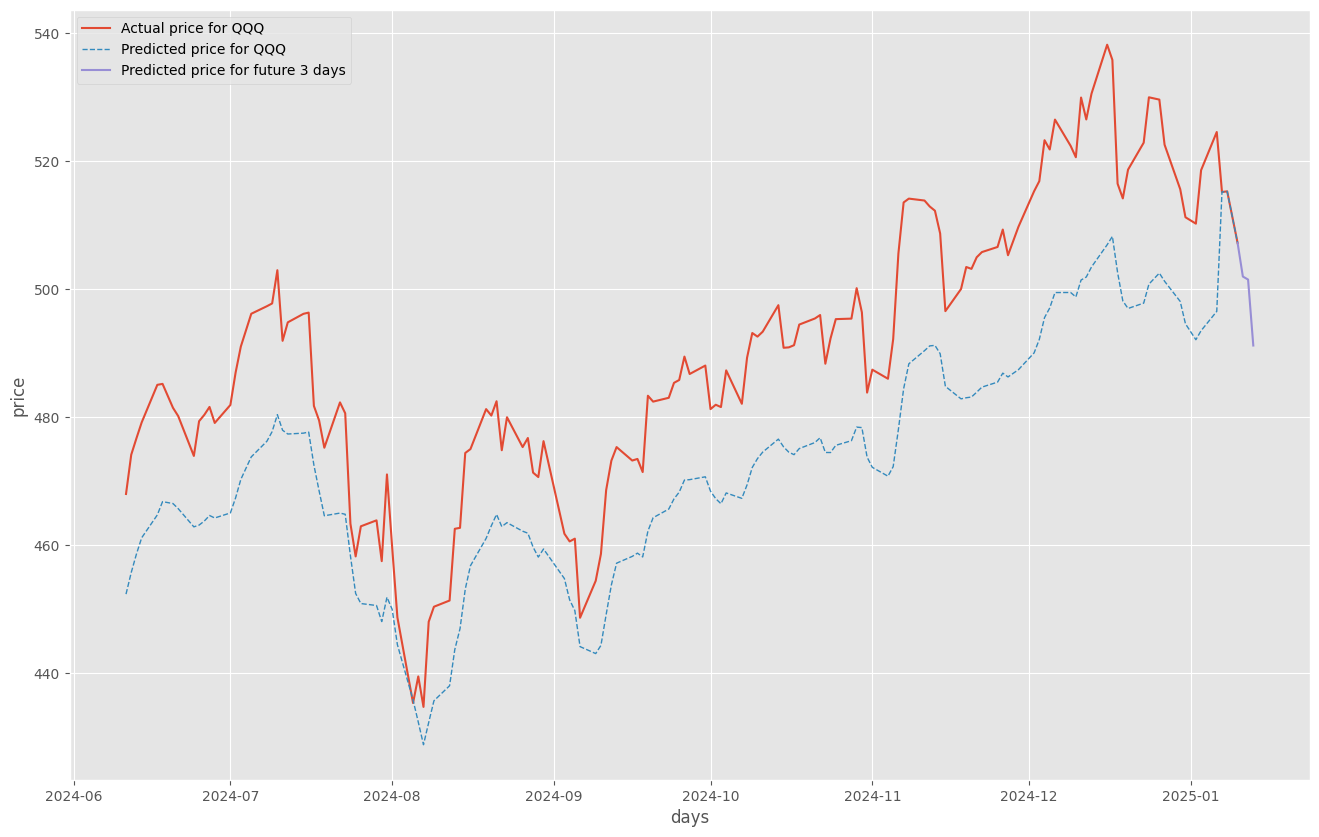

In [16]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()